# **Trend analysis for SPEAR piControl**

In [1]:
from math import nan
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from scipy.stats import linregress

In [2]:
dir1 = "/work/Jiale.Lou/shared_data/SPEAR/MED/US/"
dir2 = "/work/Darri.Stuber/spear_with_forcings_land_data"

### Import piControl simulation output, mask ocean

In [45]:
#low_pc_rh = xr.open_dataset(dir2 +f'/low_pictonrol_rh_ens.nc')
# low_pc_t= xr.open_dataset(dir2 +f'/low_pictonrol_t_ens.nc')

med_pc_rh = xr.open_dataset(dir1 + "/atmos.000101-300012.rh_ref.US.0.5x0.5.nc")
med_pc_t = xr.open_dataset(dir1 + "/atmos.000101-300012.t_ref.US.0.5x0.5.nc"

# high_pc_rh = xr.open_dataset(dir2 +f'/high_picontrol_rh_ens.nc')
# high_pc_t = xr.open_dataset(dir2 +f'/high_picontrol_t_ens.nc')

/nbhome/ogrp/python/envs/py311_20240725/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nbhome/ogrp/python/envs/py311_20240725/lib/python3.11/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/nbhome/ogrp/python/envs/py311_20240725/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nbhome/ogrp/p

In [6]:
#import sst file, use it to mask ocean data in PC
oceans_e5 = xr.open_dataset("/work/Jiale.Lou/shared_data/ERA5/ERA5_SST_10.nc")

#format sst file
ocean_mask = np.isnan(oceans_e5["sst"]) #differentiate land/ocean locations
mask1D = ocean_mask.sel(
    latitude=ocean_mask.latitude[ocean_mask.latitude % 0.5 == 0],
    longitude=ocean_mask.longitude[ocean_mask.longitude % 0.5 == 0],) #match med resolution (.5x.5)
mask1D["longitude"] = mask1D["longitude"] + 360
mask1D = mask1D.sel(latitude=slice(50, 24), longitude=slice(234, 296))

new_mask1D = mask1D.mean("time") #get rid time dim
new_mask1D = new_mask1D.sortby("latitude")
new_mask1D = new_mask1D.rename({"latitude": "lat", "longitude": "lon"})

new_mask1D

<xarray.DataArray 'sst' (lat: 53, lon: 125)> Size: 53kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float32 212B 24.0 24.5 25.0 25.5 26.0 ... 48.5 49.0 49.5 50.0
  * lon      (lon) float32 500B 234.0 234.5 235.0 235.5 ... 295.0 295.5 296.0

In [46]:
#import sst file, use it to mask ocean data in PC
oceans_e5 = xr.open_dataset("/work/Jiale.Lou/shared_data/ERA5/ERA5_SST_10.nc")

#format sst file
ocean_mask = np.isnan(oceans_e5["sst"]) #differentiate land/ocean locations
mask1D = ocean_mask.sel(
    latitude=ocean_mask.latitude[ocean_mask.latitude % 0.5 == 0],
    longitude=ocean_mask.longitude[ocean_mask.longitude % 0.5 == 0],) #match med resolution (.5x.5)
mask1D["longitude"] = mask1D["longitude"] + 360
mask1D = mask1D.sel(latitude=slice(50, 24), longitude=slice(234, 296))

new_mask1D = mask1D.mean("time") #get rid time dim
new_mask1D = new_mask1D.sortby("latitude")
new_mask1D = new_mask1D.rename({"latitude": "lat", "longitude": "lon"})

mask = new_mask1D.broadcast_like(med_pc_rh['rh_ref']) #broadcast over right time dim


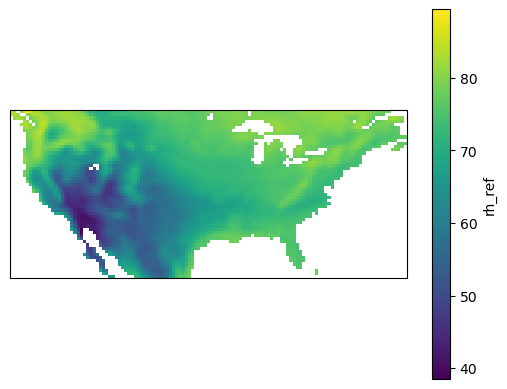

In [8]:
#mask ocean data
med_pc_rh2 = med_pc_rh['rh_ref'].where(mask == 1) 
med_pc_t2 = med_pc_t['t_ref'].where(mask == 1)

fig = plt.figure() #check
ax = fig.add_subplot( 1, 1, 1, projection=ccrs.PlateCarree()) 
med_pc_rh2.mean("time").plot()

### Calculate VP/SVP (ea/es) 

In [100]:
med_pc_rh2

<xarray.Dataset> Size: 954MB
Dimensions:  (time: 36000, lon: 125, lat: 53)
Coordinates:
  * time     (time) object 288kB 0001-01-16 12:00:00 ... 3001-01-06 12:00:00
  * lon      (lon) float64 1kB 234.0 234.5 235.0 235.5 ... 295.0 295.5 296.0
  * lat      (lat) float64 424B 24.0 24.5 25.0 25.5 26.0 ... 48.5 49.0 49.5 50.0
Data variables:
    rh_ref   (time, lat, lon) float32 954MB nan nan nan nan ... nan nan nan nan

In [101]:
# calculating DP

a1 = 243.04
a2 = 17.625

def calc_dp(rh_data, t_data):
    rh_data, t_data = rh_data.rename({"rh_ref": "dp"}), t_data.rename(
        {"t_ref": "dp"}
    )  # so final dps has a dp data variable - otherwise extract values
    td_num = a1 * (np.log(rh_data / 100) + ((a2 * t_data) / (a1 + t_data)))
    td_dem = a2 - (np.log(rh_data / 100) + ((a2 * t_data) / (a1 + t_data)))
    dps = td_num / td_dem
    return dps


In [49]:
#pc_med_dps = calc_dp(med_pc_rh2['rh_ref'], med_pc_t2['t_ref'])
med_pc_rh2 = med_pc_rh2.to_dataset()
med_pc_t2 = med_pc_t2.to_dataset()
med_pc_t2['t_ref'] = med_pc_t2['t_ref'] - 273.15

pc_med_dps = calc_dp(med_pc_rh2, med_pc_t2)
pc_low_dps = calc_dp(low_pc_rh, low_pc_t)
pc_high_dps = calc_dp(high_pc_rh, high_pc_t)

'''
#without function
td_num = a1 * (np.log(med_pc_rh2/100)+ ((a2*med_pc_t2)/(a1+med_pc_t2)))
td_dem = a2 - (np.log(med_pc_rh2/100)+ ((a2*med_pc_t2)/(a1+med_pc_t2)))
pc_med_dps = td_num/td_dem
pc_med_dps'''

'pc_low_dps = calc_dp(low_pc_rh, low_pc_t)\npc_high_dps = calc_dp(high_pc_rh, high_pc_t)'

In [50]:
pc_med_dps

<xarray.Dataset> Size: 954MB
Dimensions:  (time: 36000, lon: 125, lat: 53)
Coordinates:
  * time     (time) object 288kB 0001-01-16 12:00:00 ... 3001-01-06 12:00:00
  * lon      (lon) float64 1kB 234.0 234.5 235.0 235.5 ... 295.0 295.5 296.0
  * lat      (lat) float64 424B 24.0 24.5 25.0 25.5 26.0 ... 48.5 49.0 49.5 50.0
Data variables:
    dp       (time, lat, lon) float32 954MB nan nan nan nan ... nan nan nan nan

In [16]:
# calculate vp, svp, and vpd
c1 = 6.112  # hPa
c2 = 17.67
c3 = 243.5  #use °C

def calc_vp_stuff(dp_data, t_data):
    dew_point_temp = dp_data 
    air_temp = t_data 

    es_values = c1 * np.exp((c2 * air_temp) / (c3 + air_temp))
    es = es_values.rename({"t_ref": "es"})

    ea_values = c1 * np.exp((c2 * dew_point_temp) / (c3 + dew_point_temp))
    ea = ea_values.rename({"dp": "ea"})

    vpd_es = es_values.rename({"t_ref": "vpd"})
    vpd_ea = ea_values.rename({"dp": "vpd"})
    vpd = vpd_es - vpd_ea
    return ea, es, vpd

In [ ]:
pc_med_ea, pc_med_es, pc_med_vpd = calc_vp_stuff(pc_med_dps, med_pc_t2)
#med_pc_t2 = med_pc_t2.drop_dims('bnds')

pc_med_dps2 = pc_med_dps

pc_low_ea, pc_low_es, pc_low_vpd = calc_vp_stuff(pc_low_dps, low_pc_t)
pc_high_ea, pc_high_es, pc_high_vpd = calc_vp_stuff(pc_high_dps, high_pc_t)

In [51]:
'''#sans function
med_pc_t3 = med_pc_t2

es_values = c1 * np.exp((c2 * med_pc_t3) / (c3 + med_pc_t3)).values
ea_values = c1 * np.exp((c2 * pc_med_dps2) / (c3 + pc_med_dps2)).values

#creating new xarrays with VP/SVP/VPD
pc_med_ea = xr.Dataset({'ea': (['time', 'lat', 'lon'], ea_values)}, coords={'time': med_pc_t3.time,'lat': med_pc_t3.lat,'lon': med_pc_t3.lon})
pc_med_es = xr.Dataset({ 'es': (['time', 'lat', 'lon'], es_values)}, coords={ 'time': med_pc_t3.time,'lat': med_pc_t3.lat,'lon': med_pc_t3.lon})'''


"""pc_low_ea, pc_low_es, pc_low_vpd = calc_vp_stuff(pc_low_dps, low_pc_t)
pc_high_ea, pc_high_es, pc_high_vpd = calc_vp_stuff(pc_high_dps, high_pc_t)"""

'pc_low_ea, pc_low_es, pc_low_vpd = calc_vp_stuff(pc_low_dps, low_pc_t)\npc_high_ea, pc_high_es, pc_high_vpd = calc_vp_stuff(pc_high_dps, high_pc_t)'

### Trend calculations

In [18]:
#function to get annual southwest VP/SVP averaged spatially
def get_EA_ES(ea, es):
    ea_sw = ea.sel(lat=slice(31, 42), lon=slice(232, 258))
    es_sw = es.sel(lat=slice(31, 42), lon=slice(232, 258))

    ea_group_year_sw = ea_sw.groupby("time.year").mean(dim="time")
    EA_SW = ea_group_year_sw.groupby("year").mean(dim=["lat", "lon"])

    es_group_year_sw = es_sw.groupby("time.year").mean(dim="time")
    ES_SW = es_group_year_sw.groupby("year").mean(dim=["lat", "lon"])
    return EA_SW, ES_SW


In [52]:
pc_med_EA_SW, pc_med_ES_SW = get_EA_ES(pc_med_ea, pc_med_es)
pc_low_EA_SW, pc_low_ES_SW = get_EA_ES(pc_low_ea, pc_low_es)
pc_high_EA_SW, pc_high_ES_SW = get_EA_ES(pc_high_ea, pc_high_es)

'pc_low_EA_SW, pc_low_ES_SW = get_EA_ES(pc_low_ea, pc_low_es)\npc_high_EA_SW, pc_high_ES_SW = get_EA_ES(pc_high_ea, pc_high_es)'

In [61]:
pc_med_ea

<xarray.Dataset> Size: 954MB
Dimensions:  (time: 36000, lon: 125, lat: 53)
Coordinates:
  * time     (time) object 288kB 0001-01-16 12:00:00 ... 3001-01-06 12:00:00
  * lon      (lon) float64 1kB 234.0 234.5 235.0 235.5 ... 295.0 295.5 296.0
  * lat      (lat) float64 424B 24.0 24.5 25.0 25.5 26.0 ... 48.5 49.0 49.5 50.0
Data variables:
    ea       (time, lat, lon) float32 954MB nan nan nan nan ... nan nan nan nan

In [19]:
#get trend over specific timeframe
def new_slope(dataset, value, minyear, maxyear):
    slim_data = dataset.sel(year=slice(minyear, maxyear))
    vals = slim_data[value].values
    yrs = slim_data["year"]
    slope, intercept, r_value, p_value, std_err = linregress(yrs, vals)
    return slope

In [63]:
#generate 30 year moving trend - only using medium but could use others
pc_trend_by_30 = pd.DataFrame(columns=["year", "vp_trend", "svp_trend"])
curr_year = 3000
while curr_year >= 30:
    vp_trend = new_slope(pc_med_EA_SW, 'ea', curr_year-30,curr_year)
    s_trend = new_slope(pc_med_ES_SW, 'es', curr_year-30,curr_year)
    pc_trend_by_30.loc[len(pc_trend_by_30)] = [curr_year, vp_trend, s_trend]
    curr_year -= 1


In [65]:
#piControl does not have ens. To evaluate ens range, we divide the 30 year moving trends into 50 year periods to simulate ensembles
num_ens_values = (len(pc_trend_by_30) + 49) // 50
ens_values = np.repeat(np.arange(1, num_ens_values + 1), 50)[:len(pc_trend_by_30)]
pc_trend_by_30['ens'] = ens_values
pc_trend_by_30['year'] = pc_trend_by_30.groupby('ens').cumcount() + 1 #make each ens year start at 1


In [23]:
#get average 30 year moving trend values
def get_avg_30trend(EA_SW, ES_SW, curr_year, min_year):
    trend_by_30 = pd.DataFrame(columns=["year", "vp_trend", "svp_trend"])
    #curr_year = 2020
    while curr_year >= min_year: #1951:
        vp_trend = new_slope(EA_SW, "ea", (curr_year - 30), curr_year)
        s_trend = new_slope(ES_SW, "es", (curr_year - 30), curr_year)
        trend_by_30.loc[len(trend_by_30)] = [curr_year, vp_trend, s_trend]
        curr_year -= 1
    return trend_by_30


In [56]:
#get ensemble averages
# pc_avg_l30 = get_avg_30trend(pc_low_EA_SW.mean('ens'), pc_low_ES_SW.mean('ens'))
pc_avg_m30 = get_avg_30trend(pc_med_EA_SW, pc_med_ES_SW, 3000, 30)
# pc_avg_h30 = get_avg_30trend(pc_high_EA_SW.mean('ens'), pc_high_ES_SW.mean('ens'))

In [26]:
#store the min, 25th quartile, average, 75th, and max for all ensembles
def get_qs(trend_df, avg_trend_df):#, avg_trend_df):
    year_qs = pd.DataFrame(
        columns=["year", "ea_minimum", "ea_q1","ea_mean","ea_q3","ea_maximum","es_minimum","es_q1","es_mean", "es_q3","es_maximum",])
    for year in range(1971, 2021):
        ea_year = trend_df.loc[(trend_df["year"] == year), ["vp_trend", "svp_trend"]]
        min_ea, min_es = ea_year.min()
        q1_ea, q1_es = ea_year.quantile(0.25)
        mean_ea, mean_es = avg_trend_df.loc[avg_trend_df["year"] == year, ["vp_trend", "svp_trend"]].values[0]
        #mean_ea, mean_es = ea_year.mean()
        q3_ea, q3_es = ea_year.quantile(0.75)
        max_ea, max_es = ea_year.max()

        year_qs.loc[len(year_qs)] = [year, min_ea, q1_ea, mean_ea, q3_ea, max_ea, min_es, q1_es, mean_es, q3_es, max_es,]
    return year_qs


In [74]:
pc_trend_by_30['year'] = pc_trend_by_30['year'] +1970 #change ens years to start at 1970 for purposes of overlaying onto era data
pc_trend_by_30x = pc_trend_by_30[pc_trend_by_30['ens'] != 60]
pc_med_qs = get_qs(pc_trend_by_30x, pc_avg_m30)
#pc_low_qs = get_qs(pc_low_trend30, pc_avg_l30)
#pc_high_qs = get_qs(pc_high_trend30, pc_avg_h30)

In [75]:
pc_med_qs

,year,ea_minimum,ea_q1,ea_mean,ea_q3,ea_maximum,es_minimum,es_q1,es_mean,es_q3,es_maximum
0,1971.0,-0.020446,-0.002867,-0.005699,0.006069,0.018112,-0.024721,-0.007357,0.008199,0.007308,0.033866
1,1972.0,-0.021321,-0.003447,-0.003343,0.006585,0.019721,-0.023431,-0.005739,0.008112,0.008604,0.032358
2,1973.0,-0.018383,-0.003267,-0.005441,0.005614,0.021609,-0.025545,-0.008000,0.007516,0.007635,0.035411
3,1974.0,-0.010949,-0.002899,-0.007097,0.005926,0.023372,-0.025633,-0.006211,0.009631,0.008623,0.031647
4,1975.0,-0.012306,-0.003829,-0.005856,0.005804,0.020326,-0.028352,-0.005594,0.004131,0.008430,0.030069
5,1976.0,-0.015369,-0.003805,-0.005833,0.006761,0.019344,-0.026849,-0.006499,0.005344,0.006846,0.035052
6,1977.0,-0.015267,-0.004814,-0.002333,0.005498,0.022503,-0.021760,-0.007707,0.000484,0.007297,0.028091
7,1978.0,-0.013149,-0.003226,-0.007280,0.005766,0.019750,-0.025213,-0.006927,-0.001133,0.007723,0.027141
8,1979.0,-0.012421,-0.004202,-0.008252,0.007971,0.018425,-0.018230,-0.004171,0.001845,0.006933,0.027005
9,1980.0,-0.014240,-0.003024,-0.013593,0.006896,0.016574,-0.019468,-0.005107,-0.002588,0.007847,0.028951


### 30 Year Moving Trend Visualizations

In [27]:
era5_30trends = pd.read_csv("/work/Darri.Stuber/era5_30trends.csv") #era qs calculated using same style as above

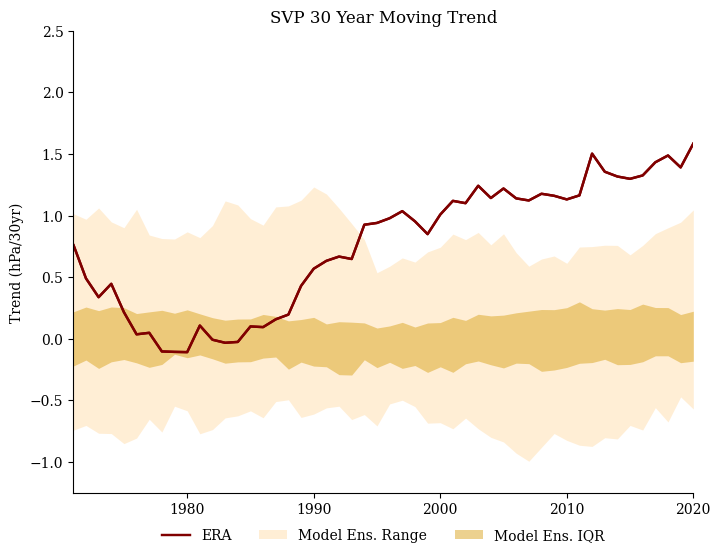

In [76]:
plt.figure(figsize=(8, 6))
plt.rcParams["font.family"] = "serif"
plt.plot( era5_30trends["year"], era5_30trends["svp_trend"] * 30, color="maroon", label="ERA", linewidth=1.75,)

plt.fill_between(pc_med_qs["year"], pc_med_qs["es_minimum"] * 30, pc_med_qs["es_maximum"] * 30, alpha=0.5, linewidth=0, color="navajowhite",label = 'Model Ens. Range')
plt.fill_between(pc_med_qs["year"], pc_med_qs["es_q1"] * 30,  pc_med_qs["es_q3"] * 30,  alpha=0.5, linewidth=0, color="goldenrod", label = 'Model Ens. IQR')

plt.plot(era5_30trends["year"], era5_30trends["svp_trend"] * 30, color="maroon", linewidth=1.75,)

plt.xlim(1971, 2020)
plt.ylim(-1.25, 2.5)
plt.ylabel("Trend (hPa/30yr)")
#plt.legend()
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow = False, frameon = False, ncol = 3)
plt.title('SVP 30 Year Moving Trend')
#plt.savefig(f'zipfiles/pc_svp_ts_plot.png', dpi=1200, bbox_inches='tight',transparent=True)
plt.show()

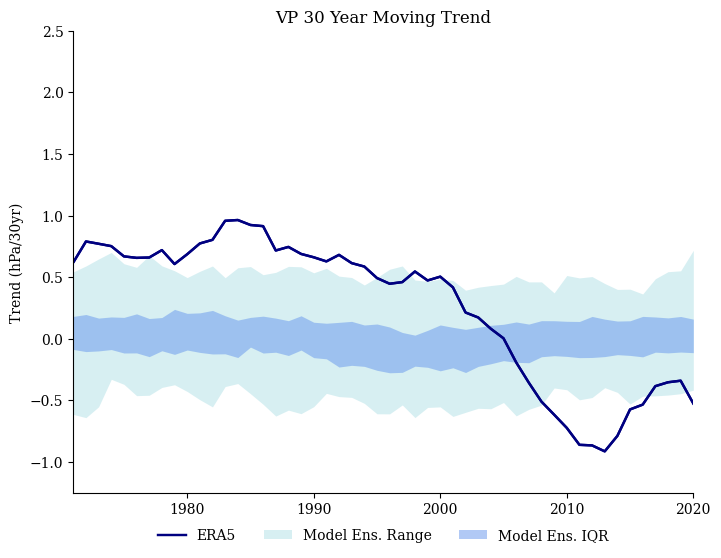

In [78]:
plt.figure(figsize=(8, 6))
plt.rcParams["font.family"] = "serif"
plt.plot( era5_30trends["year"], era5_30trends["vp_trend"] * 30, color="navy", label="ERA5", linewidth=1.75,)

plt.fill_between(pc_med_qs["year"],pc_med_qs["ea_minimum"] * 30, pc_med_qs["ea_maximum"] * 30, alpha=0.5, linewidth=0, color="powderblue",label = 'Model Ens. Range')
plt.fill_between(pc_med_qs["year"], pc_med_qs["ea_q1"] * 30, pc_med_qs["ea_q3"] * 30, alpha=0.5, linewidth=0, color="cornflowerblue",label = 'Model Ens. IQR')
plt.plot( era5_30trends["year"], era5_30trends["vp_trend"] * 30, color="navy",  linewidth=1.75,)

plt.xlim(1971, 2020)
plt.ylim(-1.25, 2.5)
plt.title('VP 30 Year Moving Trend')
plt.ylabel("Trend (hPa/30yr)")
#plt.legend()
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow = False, frameon = False, ncol = 3)
plt.savefig(f'zipfiles/pc_vp_ts_plot.png', dpi=1200, bbox_inches='tight', transparent = True)
plt.show()
